# 2. Data preparation

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('../qsar_oral_toxicity_after_profiling.csv', sep=';')

## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

### Outliers Imputation
---

In [2]:
#TODO

### Scaling

---

Since all variables are binary (0 or 1) they are already scaled. Therefore, no scaling is needed.

### Samples

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ds_functions as ds

original_copy = original.copy(deep = True)

target = 'exp'
positive = True
negative = False
values = {'Original': [len(original_copy[original_copy[target] == positive]), len(original_copy[original_copy[target] == negative])]}

y: np.ndarray = original_copy.pop(target).values
X: np.ndarray = original_copy.values
labels: np.ndarray = pd.unique(y)

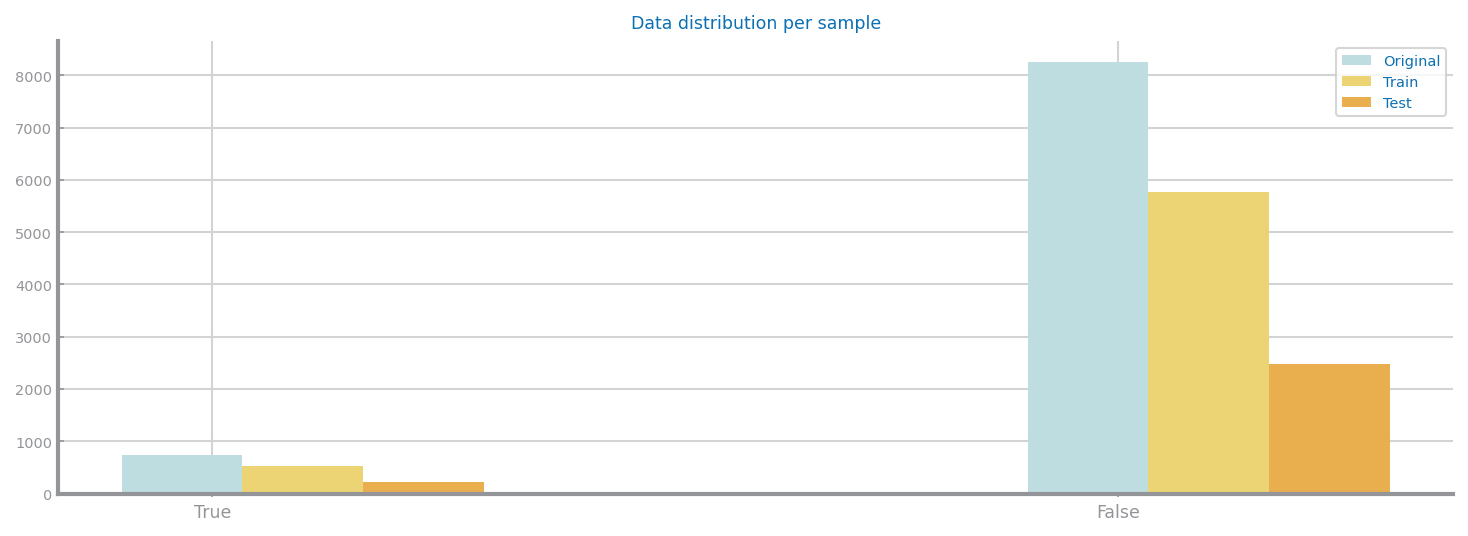

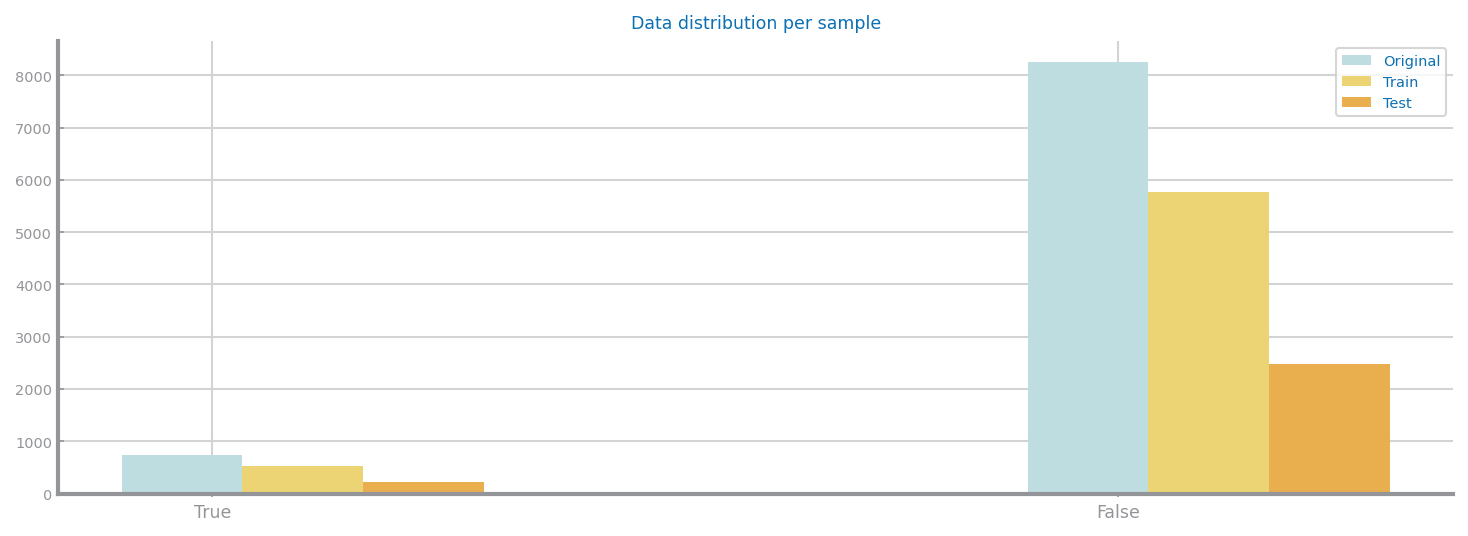

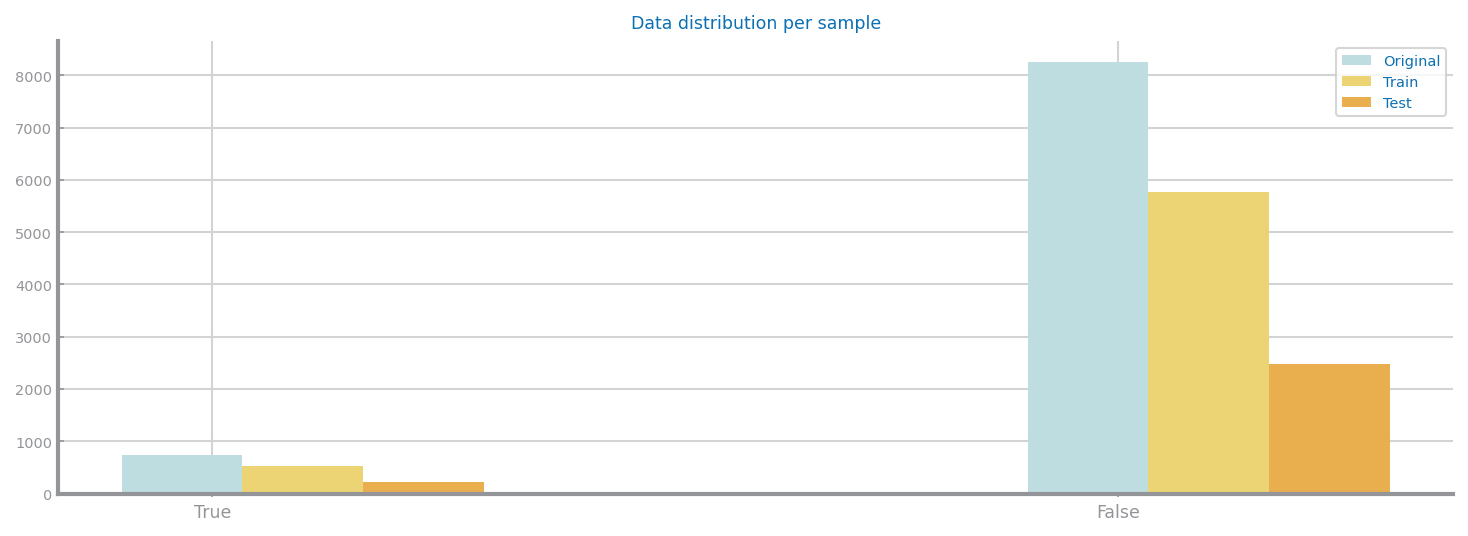

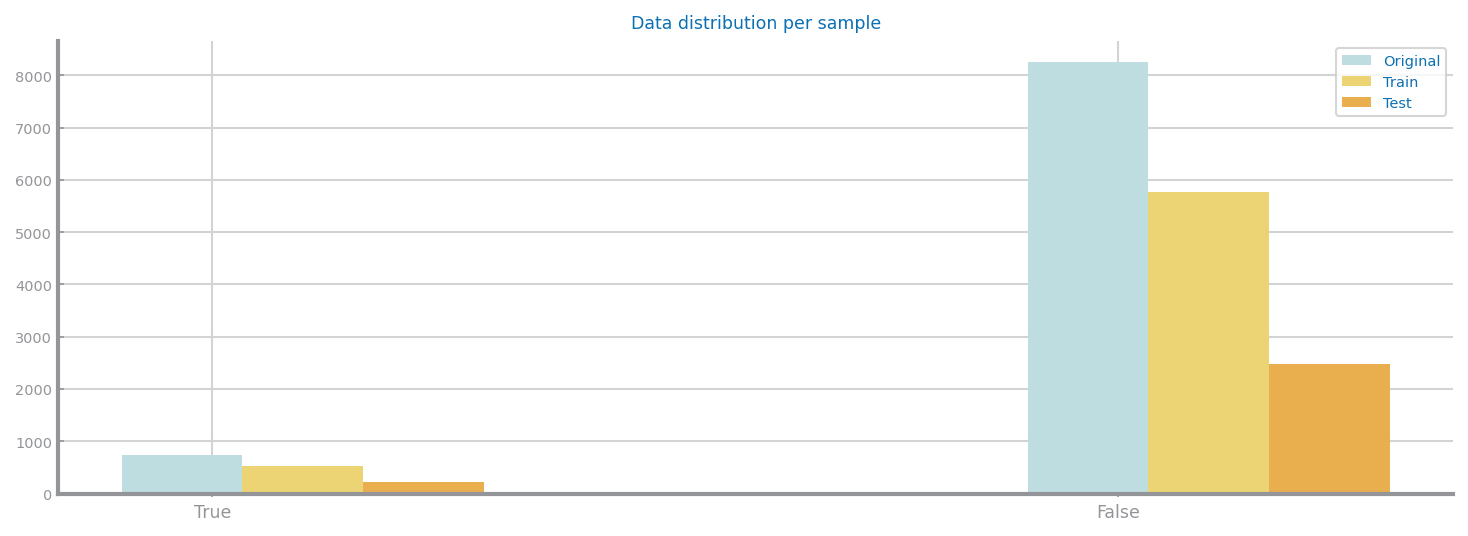

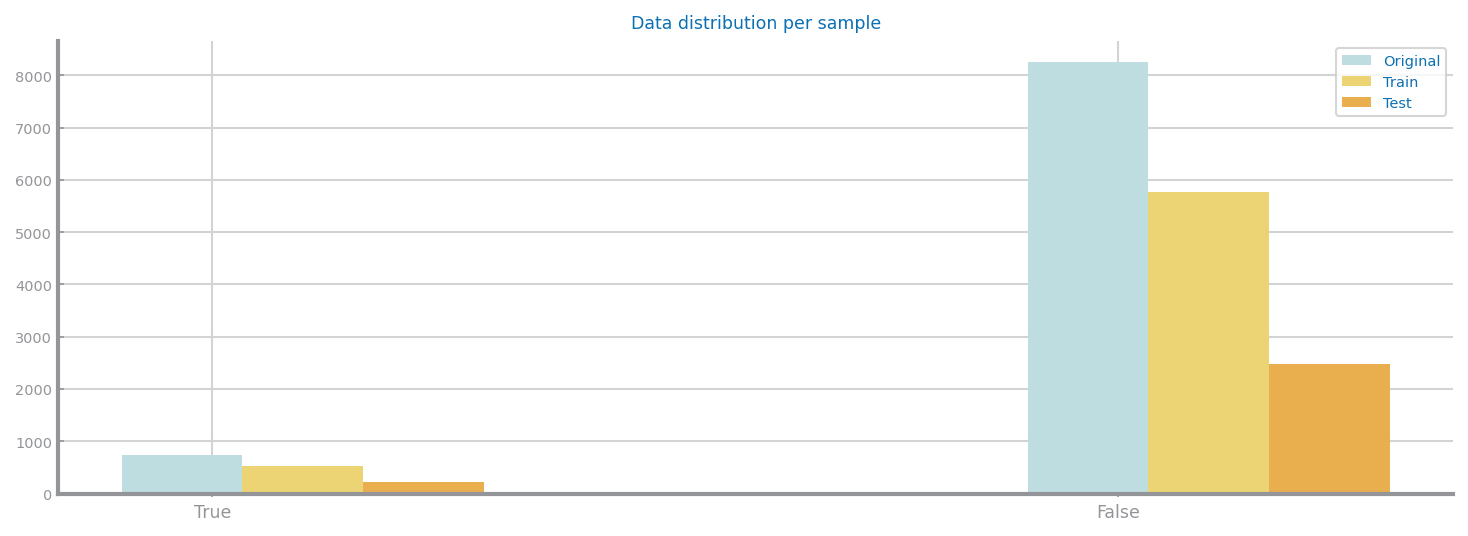

In [4]:
samples = []
n_samples = 5

for i in range(n_samples):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
    
    samples.append({'X_train': trnX, 'X_test': tstX,
                  'y_train': trnY, 'y_test': tstY})
    
    values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
    values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

    plt.figure(figsize=(12,4))
    ds.multiple_bar_chart([positive, negative], values, title='Data distribution per sample', showXTickLabels = True)
    plt.show()

### Data balancing

---

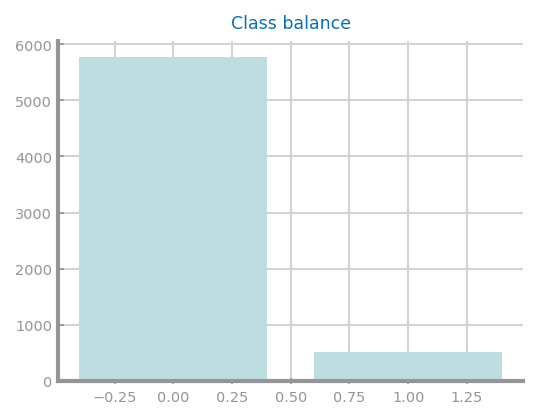

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


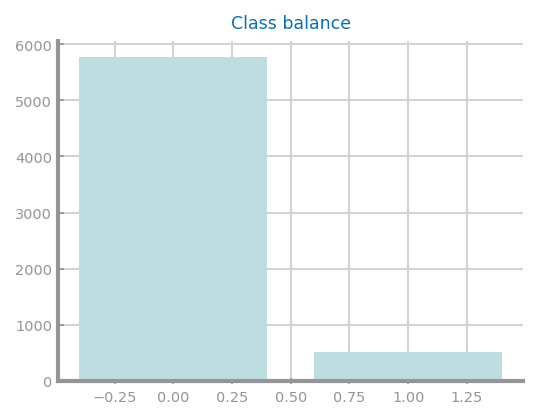

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


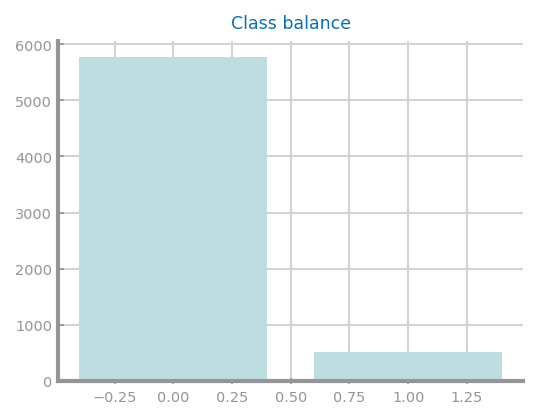

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


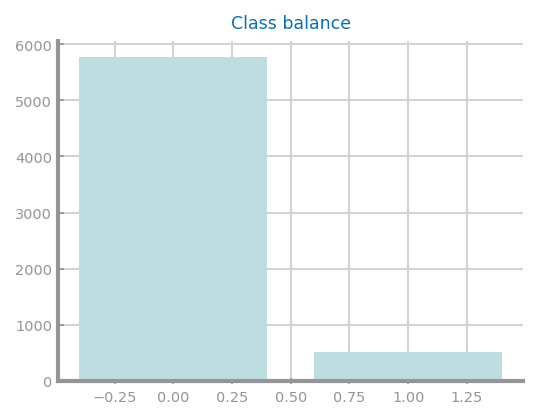

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


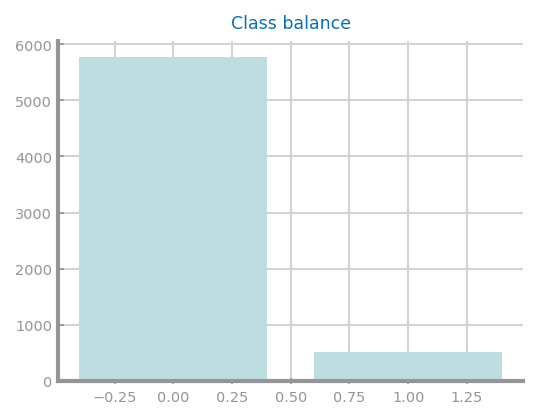

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


In [5]:
import matplotlib.pyplot as plt
columnsX = list(original.columns)
columnsX.remove(target)

for i in range(n_samples):
    sample = {}

    sample['X_train'] = pd.DataFrame(data=samples[i]['X_train'], columns=columnsX)
    sample['y_train'] = pd.DataFrame(data=samples[i]['y_train'], columns=[target])
    sample['X_test'] = pd.DataFrame(data=samples[i]['X_test'], columns=columnsX)
    sample['y_test'] = pd.DataFrame(data=samples[i]['y_test'], columns=[target])

    samples[i]['trainData'] = pd.concat([sample['X_train'], sample['y_train']], axis = 1)
    samples[i]['testData'] = pd.concat([sample['X_test'], sample['y_test']], axis = 1)

    samples[i]['target_count'] = samples[i]['trainData']['exp'].value_counts()
    plt.figure()
    plt.title('Class balance')
    plt.bar(samples[i]['target_count'].index, samples[i]['target_count'].values)
    plt.show()

    samples[i]['min_class'] = samples[i]['target_count'].idxmin()
    samples[i]['ind_min_class'] = samples[i]['target_count'].index.get_loc(samples[i]['min_class'])

    print('Minority class:', samples[i]['target_count'][samples[i]['ind_min_class']])
    print('Majority class:', samples[i]['target_count'][1-samples[i]['ind_min_class']])
    print('Proportion:', round(samples[i]['target_count'][samples[i]['ind_min_class']] / samples[i]['target_count'][1-samples[i]['ind_min_class']], 3), ': 1')

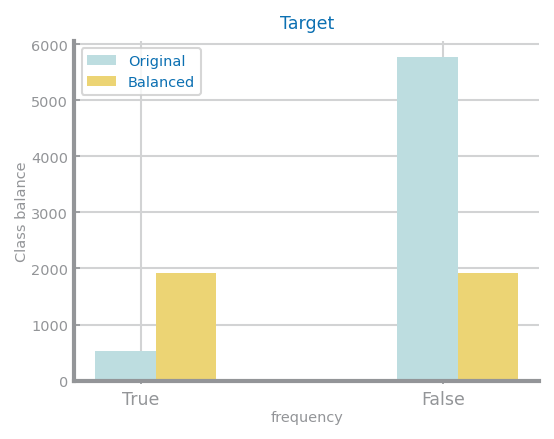

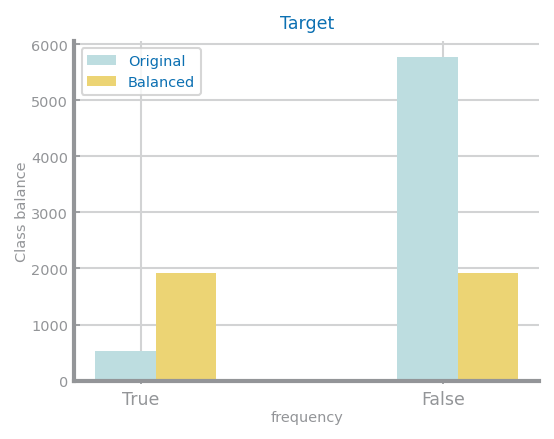

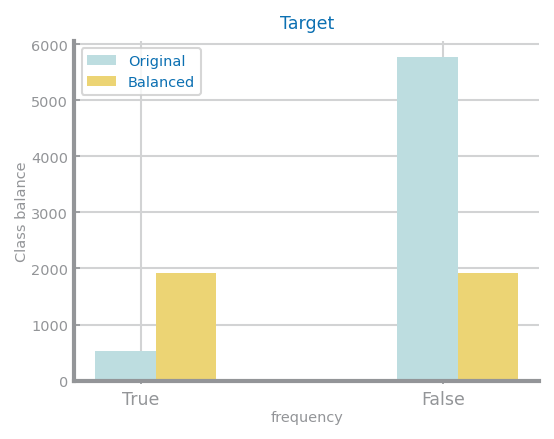

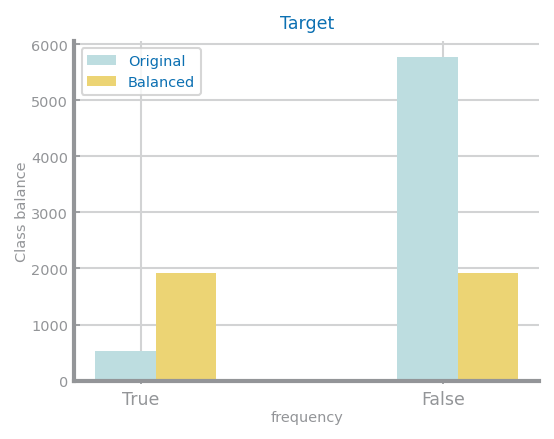

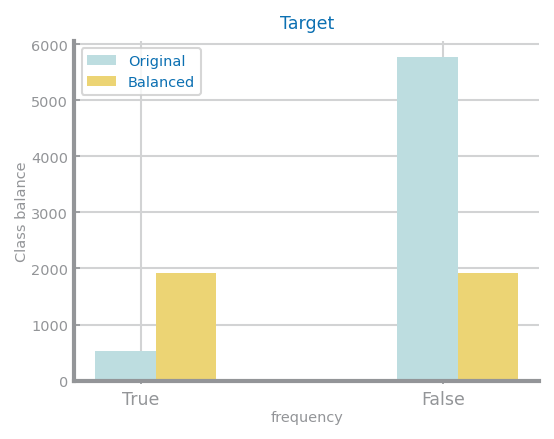

In [6]:
import ds_functions as ds

for i in range(n_samples):
    df_class_min = samples[i]['trainData'][samples[i]['trainData']['exp'] == samples[i]['min_class']]
    df_class_max = samples[i]['trainData'][samples[i]['trainData']['exp'] != samples[i]['min_class']]

    values = {'Original': [samples[i]['target_count'].values[samples[i]['ind_min_class']], samples[i]['target_count'].values[1-samples[i]['ind_min_class']]]}

    FINAL_SIZE = len(df_class_max) // 3

    # Oversampling
    df_class_min_sample = df_class_min.sample(FINAL_SIZE, replace=True)
    # Undersampling
    df_class_max_sample = df_class_max.sample(FINAL_SIZE)

    values['Balanced'] = [len(df_class_min_sample), len(df_class_max_sample)]

    fig = plt.figure()
    ds.multiple_bar_chart([samples[i]['target_count'].index[samples[i]['ind_min_class']], samples[i]['target_count'].index[1-samples[i]['ind_min_class']]], values,
                          title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
    plt.show()

    samples[i]['balanced'] = pd.concat((df_class_min_sample, df_class_max_sample))

In [7]:
for i in range(n_samples):
    samples[i]['testData'].to_csv('data/prepared_test_sample/data%d.csv' %i, sep=';', index=False)

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [8]:
import seaborn as sns
import numpy as np

data_dict = []
data_dict_unsupervised = []

for i in range(n_samples):
    data_dict.append({'balanced': samples[i]['balanced']})
    data_dict_unsupervised.append({'balanced': None})

    for key in data_dict[i]:
        df = data_dict[i][key]

        copy = df.copy(deep=True)
        copy = copy.drop('exp', axis = 1)
        corrs = copy.corr()

        removed = []

        for x in corrs:
            for y in corrs:
                if x == y:
                    break
                corr = corrs[x][y]
                if abs(corr) >= 0.8 and x not in removed and y not in removed:
                    copy = copy.drop(x, axis=1)
                    removed.append(x)
                    break

        copy['exp'] = df['exp']

        data_dict_unsupervised[i][key] = copy.copy(deep=True)

#### Supervised Selection

In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.

In [9]:
importances = []

for i in range(n_samples):
    importances.append({'balanced': None})

    for key in data_dict_unsupervised[i]:
        importances[i][key] = data_dict_unsupervised[i][key].drop('exp', axis=1).apply(lambda x: x.corr(copy.exp))
        print('%s\n\n' % key, importances[i][key], '\n\n\n')

balanced

 bmf1       0.052747
bmf2      -0.054649
bmf3      -0.057873
bmf4      -0.084131
bmf5       0.073510
             ...   
bmf1020    0.020076
bmf1021    0.028640
bmf1022   -0.006890
bmf1023    0.017446
bmf1024   -0.041410
Length: 964, dtype: float64 



balanced

 bmf1      -0.048247
bmf2      -0.037372
bmf3      -0.003890
bmf4       0.027168
bmf5      -0.040260
             ...   
bmf1020   -0.010031
bmf1021   -0.029397
bmf1022   -0.069494
bmf1023   -0.041172
bmf1024   -0.031829
Length: 963, dtype: float64 



balanced

 bmf1      -0.023232
bmf2      -0.000635
bmf3      -0.042995
bmf4      -0.122543
bmf5       0.030044
             ...   
bmf1020   -0.027372
bmf1021   -0.041789
bmf1022    0.026723
bmf1023    0.022696
bmf1024   -0.052050
Length: 962, dtype: float64 



balanced

 bmf1       0.035204
bmf2      -0.101475
bmf3       0.019506
bmf4       0.068115
bmf5       0.079872
             ...   
bmf1020    0.005760
bmf1021   -0.041297
bmf1022    0.057402
bmf1023   -0.029951


In [10]:
new_data_dict_unsupervised = []

for i in range(n_samples):
    new_data_dict_unsupervised.append({'balanced': None})
    
    for key in data_dict_unsupervised[i]:
        new_data_dict_unsupervised[i][key] = data_dict_unsupervised[i][key].copy(deep=True)

        for j in range(0, len(importances[i][key])):
            if np.abs(importances[i][key][j]) < 0.10:
                new_data_dict_unsupervised[i][key] = new_data_dict_unsupervised[i][key].drop(importances[i][key].index[j], axis=1)

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

newest_copy = []

for i in range(n_samples):
    newest_copy.append({'balanced': None})
    
    for key in new_data_dict_unsupervised[i]:
        newest_copy[i][key] = new_data_dict_unsupervised[i][key].copy(deep=True)

        X = pd.get_dummies(newest_copy[i][key].drop('exp', axis=1))
        y = pd.get_dummies(newest_copy[i][key]['exp'])


        #feature selection using chi2
        bestfeatures = SelectKBest(score_func=chi2, k='all')
        fit = bestfeatures.fit(X, y)
        #create df for scores
        dfscores = pd.DataFrame(fit.scores_)
        #create df for column names
        dfcolumns = pd.DataFrame(X.columns)

        #concat two dataframes for better visualization 
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        #naming the dataframe columns
        featureScores.columns = ['Selected_columns','Score_chi2']

        for j in range(0, len(featureScores)):
            if featureScores['Score_chi2'][j] <= 50:
                newest_copy[i][key] = newest_copy[i][key].drop(featureScores['Selected_columns'][j], axis=1)

In [12]:
for i in range(n_samples):
    newest_copy[i]['balanced'].to_csv('data/prepared_b_s_sample/data%d.csv' %i, sep=';', index=False)

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

Yes, they are all binary and, therefore, all in the same scale.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is way unbalanced. To balance it we used two techniques: oversampling for the minority class (positive) and undersampling for the majority class (negative).